# Feature Selection



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel
from bartpy.featureselection import SelectNullDistributionThreshold, SelectSplitProportionThreshold
from bartpy.diagnostics.features import *

%matplotlib inline

Text(0.5,1,'X v y')

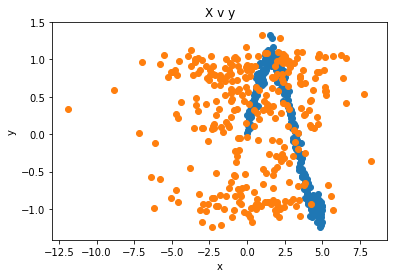

In [2]:
x = np.linspace(0, 5, 300)
X = np.random.normal(0, 3, size = 300 * 2).reshape(300, 2)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=300) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

In [19]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=50, store_in_sample_predictions=False, n_jobs=1)
model.fit(X, y)

Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.27it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.97it/s]


Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.37it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.55it/s]


Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.81it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.82it/s]


Starting burn


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.81it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 51.12it/s]


SklearnModel(alpha=0.95, beta=2.0, n_burn=50, n_chains=4, n_jobs=1,
       n_samples=200, n_trees=50, p_grow=0.5, p_prune=0.5, sigma_a=0.001,
       sigma_b=0.001, store_acceptance_trace=True,
       store_in_sample_predictions=False, thin=0.1)

In [12]:
len(model.extract[0]["acceptance"])

20

C:\Users\jacoltman\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


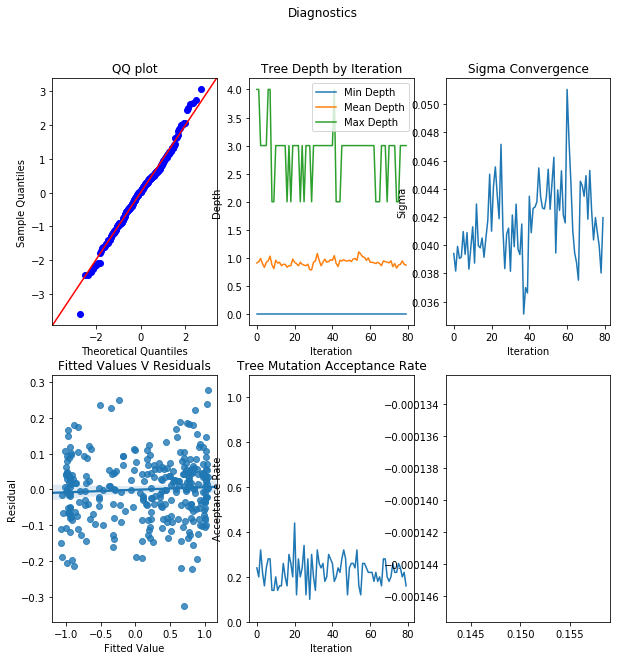

In [20]:
from matplotlib import pyplot as plt

from bartpy.diagnostics.residuals import plot_qq, plot_homoskedasity_diagnostics
from bartpy.diagnostics.sampling import plot_tree_mutation_acceptance_rate
from bartpy.diagnostics.sigma import plot_sigma_convergence
from bartpy.diagnostics.trees import plot_tree_depth
from bartpy.sklearnmodel import SklearnModel


def plot_diagnostics(model: SklearnModel):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 10))
    fig.suptitle("Diagnostics")
    plot_qq(model, ax1)
    plot_tree_depth(model, ax2)
    plot_sigma_convergence(model, ax3)
    plot_homoskedasity_diagnostics(model, ax4)
    plot_tree_mutation_acceptance_rate(model, ax5)
    plt.show()

plot_diagnostics(model)

(0, 1)

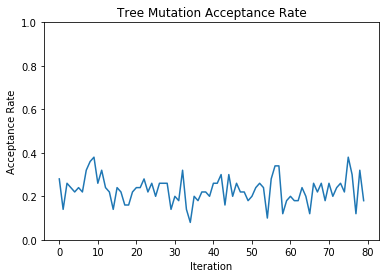

In [15]:
fig, ax = plt.subplots(1, 1)

ax.plot([x["Tree"] for x in model.acceptance_trace])
ax.set_title("Tree Mutation Acceptance Rate")
ax.set_xlabel("Iteration")
ax.set_ylabel("Acceptance Rate")
ax.set_ylim((0, 1))

# Sklearn API

Feature selection can be done in BartPy using the Sklearn selector API.  This allows for deep integration with the Sklearn pipelines

### Proportion Threshold

The simplest way to select features is to set a threshold on how often a variable is used in splits in the model trees.  The more times a tree appears in the model, the more likely it is that the feature is important and captures a meaningful pattern.

While this method is simple, the downside is that it is hard to set the threshold appropriately.  Cross validation is recommended

In [16]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False)
pipeline = make_pipeline(SelectSplitProportionThreshold(model, 0.3), model)
pipeline_model = pipeline.fit(X, y)

PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
print("Feature Proportions", pipeline_model.named_steps["selectsplitproportionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectsplitproportionthreshold"]._get_support_mask())

In [ ]:
plt.scatter(model.predict(X), y)

In [ ]:
pipeline_model.named_steps["selectsplitproportionthreshold"].plot()

### Null Distribution Threshold

For a more principled analysis, BartPy implements the method described in https://repository.upenn.edu/cgi/viewcontent.cgi?article=1555&context=statistics_papers.

This is significantly more computationally expensive, but offers a principled way to set proportions

In [20]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=1)
pipeline = make_pipeline(SelectNullDistributionThreshold(model, 0.9, "local"), model)
pipeline_model = pipeline.fit(X, y)

Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.65it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 114.72it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 46.09it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 105.75it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 104.17it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 115.35it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 132.36it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 123.05it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 103.09it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 111.13it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 85.28it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 125.92it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 122.15it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.10it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.77it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 86.25it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 120.79it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 107.26it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 105.11it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.30it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 80.95it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 97.73it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 122.15it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.21it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.89it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.92it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 97.13it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 103.19it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.41it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.65it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.53it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 93.34it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.95it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 115.21it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.60it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 127.42it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 126.95it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.37it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 130.05it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 115.74it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.53it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 103.37it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 120.16it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.52it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 88.65it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 100.86it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 110.02it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 109.22it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.23it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 58.58it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:50<00:00, 17.17it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.36it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.47it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.43it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 54.47it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.78it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 83.98it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 111.12it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 120.48it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 121.37it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 127.44it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 124.91it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 88.00it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.86it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 108.08it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 102.42it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 115.97it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 110.13it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.77it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 115.18it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 125.88it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 115.77it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 109.40it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 114.20it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 117.29it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 115.43it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 96.93it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 108.13it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 112.40it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.16it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 121.20it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 102.92it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 94.99it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 109.30it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 106.13it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 109.81it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.04it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 114.44it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 98.73it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 106.29it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 107.62it/s]


Starting sampling


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 88.83it/s]


Starting burn


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 93.83it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 127.93it/s]


Starting burn


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 116.33it/s]


Starting sampling


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 100.83it/s]


In [11]:
import numpy as np
np.array([1, 2, 3,4]).reshape(2, 2)[:,]

array([[1, 2],
       [3, 4]])

In [21]:
print("Thresholds", pipeline_model.named_steps["selectnulldistributionthreshold"].thresholds)
print("Feature Proportions", pipeline_model.named_steps["selectnulldistributionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectnulldistributionthreshold"]._get_support_mask())

Thresholds {0: 0.34063023034076845, 1: 0.1695974590034498}
Feature Proportions {0: 0.3748764822134387, 1: 0.3780879446640316}
Is Kept [ True  True]


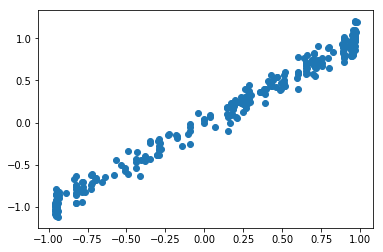

In [22]:
plt.scatter(model.predict(X), y)

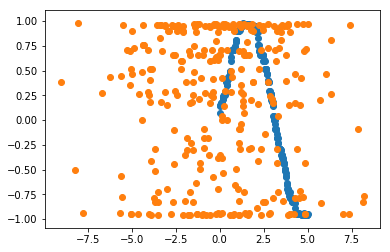

In [23]:
plt.scatter(X[:,0], model.predict(X))
plt.scatter(X[:,1], model.predict(X))

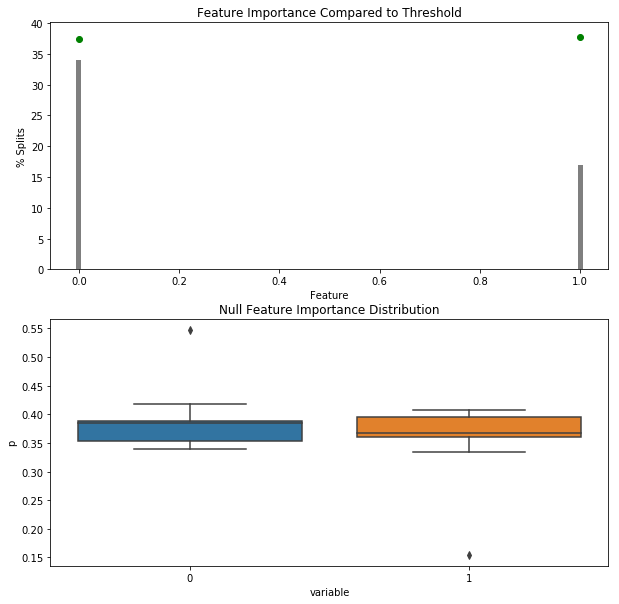

In [24]:
pipeline_model.named_steps["selectnulldistributionthreshold"].plot()

# Feature Selection

The approach so far is useful - but it doesn't give a complete picture of the importance of a single variable.  There are at least two big limitations:
1. % of splits doesn't give up an idea of how much a variable is improving accuracy
2. In cases of high correlation, the model might be able to as easily split on different variables

To get a more direct account of a single variable, we can instead permute that variable, and see how the out of sample RMSE changes.  The bigger the increase in RMSE that scrambling a variable, the more important the variable is.

([1.2875442589640158, 1.5349302151957973],
 [8.694809737061329,
  8.520081849762558,
  8.60005007961278,
  8.926416162399375,
  9.027468430662955,
  8.561770647642888,
  8.727273573769576,
  8.557241867849276,
  8.967567197121092,
  8.567056560102573,
  8.73193296923612,
  8.7067502135217,
  8.972313254229007,
  8.35214212700273,
  8.651288046527648,
  8.724776385402956,
  8.567256962305356,
  8.73687581985247,
  9.05547752801785,
  8.725922157383227])

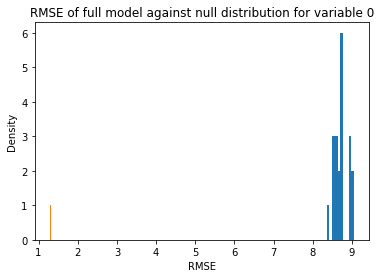

In [51]:
feature_importance(model, X, y, 0)

In [ ]:
from bartpy.diagnostics.diagnostics import plot_diagnostics
plot_diagnostics(model)